## 1. Dependencies

In [3]:
# %cd /content/drive/MyDrive/MyApps/translation_app_with_k8s/model_dev/data

In [4]:
# !tar -xvf /content/drive/MyDrive/MyApps/translation_app_with_k8s/model_dev/data/raw.tar.gz

In [5]:
# file_name = cache_file("/content/drive/MyDrive/MyApps/translation_app_with_k8s/model_dev/data/raw/raw.tsv",url=)

In [29]:
!pip install --upgrade pip setuptools
!pip install fugashi[unidic]
!python -m unidic download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unidic: filename=unidic-1.1.0-py3-none-any.whl size=7409 sha256=728239bd7bce5e64a68963116c3a2e483ce243aa31357abae8db9e11eb914790
  Stored in directory: /root/.cache/pip/wheels/ce/4d/f1/170bb74b559ca338113c0315c9805e16dfd0a12411ec6b1122
Successfully built unidic
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:28<00:00, 18.7MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.7/dist-packages/unidic/dicdir


## 2. EDA

In [43]:
%cd /content/drive/MyDrive/MyApps/translation_app_with_k8s/model_dev

/content/drive/MyDrive/MyApps/translation_app_with_k8s/model_dev


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
df = pd.read_csv("./data/raw.csv",delimiter='\t',header=None, names=['en', 'ja'])

In [45]:
df['en_len'] = df['en'].apply(lambda x: len(x))
df['ja_len'] = df['ja'].apply(lambda x: len(x))

In [46]:
df.head()

,en,ja,en_len,ja_len
0,"you are back, aren't you, harold?",あなたは戻ったのね ハロルド?,33,15
1,my opponent is shark.,俺の相手は シャークだ。,21,12
2,this is one thing in exchange for another.,引き換えだ ある事とある物の,42,14
3,"yeah, i'm fine.",もういいよ ごちそうさま ううん,15,16
4,don't come to the office anymore. don't call m...,もう会社には来ないでくれ 電話もするな,55,19


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2698102 entries, 0 to 2698101
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   en      object
 1   ja      object
 2   en_len  int64 
 3   ja_len  int64 
dtypes: int64(2), object(2)
memory usage: 82.3+ MB


In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
en_len,2698102.0,36.174860,21.272782,2.0,21.0,32.0,47.0,352.0
ja_len,2698102.0,16.873254,156.253525,1.0,9.0,13.0,19.0,47157.0


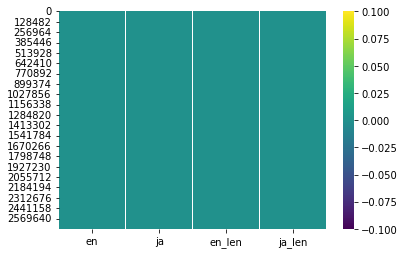

In [49]:
sns.heatmap(df.isnull(),cmap="viridis")

In [50]:
print(df.isnull().any()) # nullはなし

en        False
ja        False
en_len    False
ja_len    False
dtype: bool


In [90]:
df = df.sample(250000) #250,000行をサンプル

## 3. Preprocessing

### 3-1 日本語訳をわかち書きにする

In [51]:
from fugashi import Tagger

In [52]:
tagger = Tagger('-Owakati')

In [53]:
text = "麩菓子は、麩を主材料とした日本のお菓子。"

In [54]:
tagger.parse(text)

'麩 菓子 は 、 麩 を 主材 料 と し た 日本 の お 菓子 。'

In [55]:
 df['ja'] = df['ja'].apply(lambda x: tagger.parse(x))

In [56]:
df.head()

,en,ja,en_len,ja_len
0,"you are back, aren't you, harold?",あなた は 戻っ た の ね ハロルド ?,33,15
1,my opponent is shark.,俺 の 相手 は シャーク だ 。,21,12
2,this is one thing in exchange for another.,引き換え だ ある 事 と ある 物 の,42,14
3,"yeah, i'm fine.",もう いい よ ご ちそう さま ううん,15,16
4,don't come to the office anymore. don't call m...,もう 会社 に は 来 ない で くれ 電話 も する な,55,19


In [91]:
df[['en','ja']].to_csv("./data/en-ja.csv", index = False, sep='\t')

### 3-2 学習するための前処理の定義

In [92]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
SOS_token = 0
EOS_token = 1

In [94]:
SOS_token = 0
EOS_token = 1

 # word2index, word2count, index2wordのdictを作成するためのクラス
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [109]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # s = re.sub(r"([.!?])", r" \1", s) #日本語にこの正規化処理を行うとバグるのでいったんコメントアウト
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [110]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.csv' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in tqdm(lines)]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in tqdm(pairs)]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [111]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)


# def filterPairs(pairs):
#     return [pair for pair in pairs if filterPair(pair)]

In [112]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # pairs = filterPairs(pairs)
    # print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in tqdm(pairs):
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [113]:
from tqdm.notebook import tqdm

### 3-3 前処理後の確認

In [114]:
input_lang, output_lang, pairs = prepareData('en', 'ja', True)
print(random.choice(pairs))

Reading lines...


  0%|          | 0/250001 [00:00<?, ?it/s]

  0%|          | 0/250001 [00:00<?, ?it/s]

Read 250001 sentence pairs
Counting words...


  0%|          | 0/250001 [00:00<?, ?it/s]

Counted words:
ja 62334
en 96420
['トラム の 事 て ニーマン は 傷つい てる みたい た', 'things were hurting with neiman on the kits.']


In [116]:
print(random.choice(pairs))

['明石 の 元 部下 て 今 は 厚生 労働 省 から', "he's a former subordinate for akashi, and he's now come down"]


In [122]:
print(f'input_lang.name:{input_lang.name}')
print(f'output_lang.name:{output_lang.name}')

input_lang.name:ja
output_lang.name:en


In [128]:
import itertools

In [130]:
print(f'input_lang.word2index:{dict(itertools.islice(input_lang.word2index.items(),10))}')
print(f'output_lang.word2index:{dict(itertools.islice(output_lang.word2index.items(),10))}')

input_lang.word2index:{'ja': 2, 'ありかとう': 3, 'こさい': 4, 'ます': 5, '今夜': 6, 'も': 7, '残っ': 8, 'て': 9, 'やっ': 10, 'き': 11}
output_lang.word2index:{'en': 2, 'thank': 3, 'you': 4, 'very': 5, 'much.': 6, "i'll": 7, 'finish': 8, 'up': 9, 'tonight.': 10, 'scarlett': 11}


In [131]:
print(f'input_lang.word2count:{dict(itertools.islice(input_lang.word2count.items(),10))}')
print(f'output_lang.word2count:{dict(itertools.islice(output_lang.word2count.items(),10))}')

input_lang.word2count{'ja': 4, 'ありかとう': 1174, 'こさい': 585, 'ます': 13815, '今夜': 278, 'も': 25950, '残っ': 194, 'て': 98962, 'やっ': 2575, 'き': 2190}
output_lang.word2count:{'en': 17, 'thank': 1473, 'you': 46946, 'very': 2157, 'much.': 309, "i'll": 2683, 'finish': 142, 'up': 3421, 'tonight.': 160, 'scarlett': 4}


In [132]:
print(f'input_lang.index2word:{dict(itertools.islice(input_lang.index2word.items(),10))}')
print(f'output_lang.word2count:{dict(itertools.islice(output_lang.index2word.items(),10))}')

input_lang.index2word{0: 'SOS', 1: 'EOS', 2: 'ja', 3: 'ありかとう', 4: 'こさい', 5: 'ます', 6: '今夜', 7: 'も', 8: '残っ', 9: 'て'}
output_lang.word2count:{0: 'SOS', 1: 'EOS', 2: 'en', 3: 'thank', 4: 'you', 5: 'very', 6: 'much.', 7: "i'll", 8: 'finish', 9: 'up'}


In [135]:
print(f'n_words:{input_lang.n_words}')
print(f'n_words:{output_lang.n_words}')

n_words:62334
n_words:96420


## 4. Seq2Seq Modeling

In [137]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [160]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [161]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 5. Define objects to tranin the model

### 5-1. Preparing Training Data

In [162]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 5-2. Training the Model

In [170]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        try: # Index Errorがでるため
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        except IndexError:
            pass

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [164]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [173]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [166]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [167]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [168]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

  0%|          | 0/62500 [00:00<?, ?it/s]

0m 35s (- 59m 1s) (625 1%) 6.3208
1m 7s (- 54m 59s) (1250 2%) 5.9682
1m 39s (- 53m 31s) (1875 3%) 5.7996
2m 12s (- 53m 6s) (2500 4%) 5.6689
2m 44s (- 52m 10s) (3125 5%) 5.6168
3m 16s (- 51m 23s) (3750 6%) 5.6479
4m 0s (- 53m 8s) (4375 7%) 5.6114
4m 32s (- 52m 12s) (5000 8%) 5.5987
5m 4s (- 51m 23s) (5625 9%) 5.4791
5m 37s (- 50m 38s) (6250 10%) 5.7351
6m 11s (- 50m 5s) (6875 11%) 5.6793
6m 43s (- 49m 21s) (7500 12%) 5.5144
7m 16s (- 48m 43s) (8125 13%) 5.6823
7m 51s (- 48m 16s) (8750 14%) 5.5277
8m 30s (- 48m 13s) (9375 15%) 5.5987
9m 3s (- 47m 35s) (10000 16%) 5.4593
9m 35s (- 46m 52s) (10625 17%) 5.5744
10m 7s (- 46m 7s) (11250 18%) 5.4889
10m 52s (- 46m 20s) (11875 19%) 5.6045
11m 26s (- 45m 45s) (12500 20%) 5.5802
11m 59s (- 45m 5s) (13125 21%) 5.5576
12m 32s (- 44m 28s) (13750 22%) 5.6034
13m 5s (- 43m 50s) (14375 23%) 5.5433
13m 38s (- 43m 11s) (15000 24%) 5.4536
14m 10s (- 42m 31s) (15625 25%) 5.4753
14m 56s (- 42m 30s) (16250 26%) 5.5479
15m 32s (- 42m 2s) (16875 27%) 5.4624
16

<Figure size 432x288 with 0 Axes>

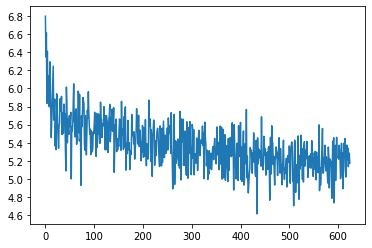

In [199]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

n_iters = int(len(df)/4)
print_every = int(n_iters/100)
trainIters(encoder1, attn_decoder1, n_iters, print_every=print_every)

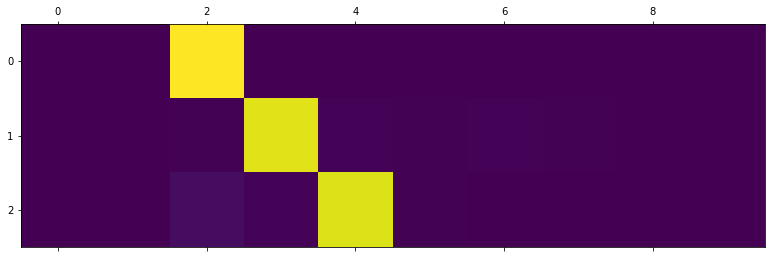

In [202]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "私 は 鈴木")
plt.matshow(attentions.numpy())

input = 俺 の 相手 は シャーク
output = i i a <EOS>
input = 私 は
output = i <EOS>


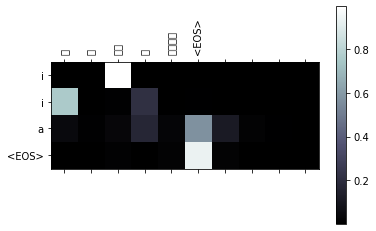

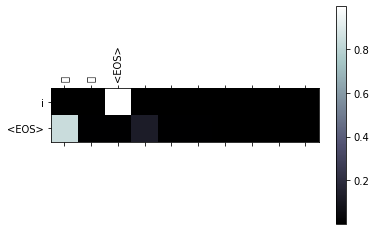

In [207]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("俺 の 相手 は シャーク")

evaluateAndShowAttention("私 は")

# evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")